# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

### Initiation Directory

In [2]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 4,
    shuffle=False
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, 
                        input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = True
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(64,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, 
                       activation='softmax'))
print(model_resnet.summary())

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         524544    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 64)          16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________

In [5]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator #,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 151s 359ms/step - loss: 2.8223 - acc: 0.2110 - val_loss: 2.1351 - val_acc: 0.2189
Epoch 2/30
380/380 [==============================] - 96s 251ms/step - loss: 2.4983 - acc: 0.2286 - val_loss: 1.9844 - val_acc: 0.2413
Epoch 3/30
380/380 [==============================] - 95s 250ms/step - loss: 2.2396 - acc: 0.2743 - val_loss: 1.6915 - val_acc: 0.3289
Epoch 4/30
380/380 [==============================] - 95s 249ms/step - loss: 2.0913 - acc: 0.3074 - val_loss: 1.4922 - val_acc: 0.4216
Epoch 5/30
380/380 [==============================] - 95s 250ms/step - loss: 1.9114 - acc: 0.3447 - val_loss: 1.4153 - val_acc: 0.4460
Epoch 6/30
380/380 [==============================] - 94s 247ms/step - loss: 1.8000 - acc: 0.3758 - val_loss: 1.3460 - val_acc: 0.4745
Epoch 7/30
380/380 [==============================] - 94s 248ms/step - loss: 1.6720 - acc: 0.3992 - val_loss: 1.2566 - val_acc: 0.5132
Epoch 8/30
380/380 [==============================] - 

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

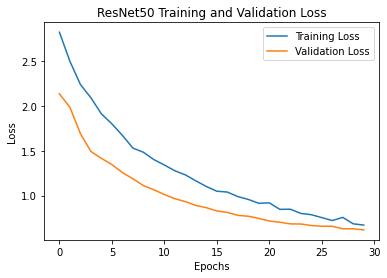

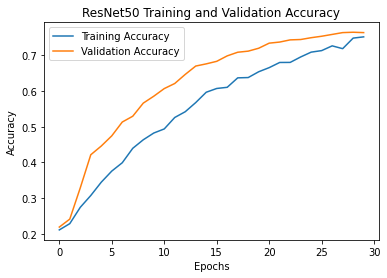

In [6]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 6s 26ms/step - loss: 0.6171 - acc: 0.7637
Loss: 0.6170754432678223
Accuracy: 0.7637474536895752


In [8]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 Training classification report:\n", train_class_report)



380/380 [==============================] - 86s 225ms/step

ResNet50 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19841   0.20492   0.20161      1220
            covid19    0.20289   0.21480   0.20868      1243
             normal    0.21867   0.21053   0.21452      1235
       tuberculosis    0.18470   0.16923   0.17663      1170
    viral_pneumonia    0.21480   0.22030   0.21752      1212

           accuracy                        0.20428      6080
          macro avg    0.20390   0.20396   0.20379      6080
       weighted avg    0.20407   0.20428   0.20404      6080



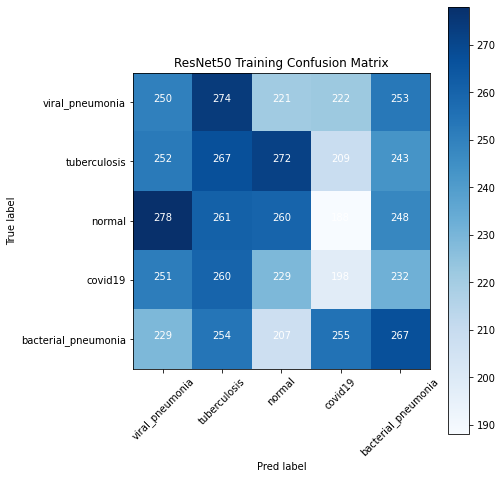

In [9]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [10]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(256,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(64,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_______________________________________________________

In [11]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 119s 294ms/step - loss: 1.6545 - acc: 0.2666 - val_loss: 1.3706 - val_acc: 0.5112
Epoch 2/30
380/380 [==============================] - 108s 285ms/step - loss: 1.2716 - acc: 0.4594 - val_loss: 1.0059 - val_acc: 0.6242
Epoch 3/30
380/380 [==============================] - 109s 286ms/step - loss: 0.9493 - acc: 0.6071 - val_loss: 0.7895 - val_acc: 0.6935
Epoch 4/30
380/380 [==============================] - 109s 285ms/step - loss: 0.8121 - acc: 0.6615 - val_loss: 0.6985 - val_acc: 0.7067
Epoch 5/30
380/380 [==============================] - 109s 287ms/step - loss: 0.7353 - acc: 0.6962 - val_loss: 0.6439 - val_acc: 0.7576
Epoch 6/30
380/380 [==============================] - 109s 286ms/step - loss: 0.6938 - acc: 0.7094 - val_loss: 0.6164 - val_acc: 0.7566
Epoch 7/30
380/380 [==============================] - 109s 287ms/step - loss: 0.6289 - acc: 0.7395 - val_loss: 0.6708 - val_acc: 0.7200
Epoch 8/30
380/380 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

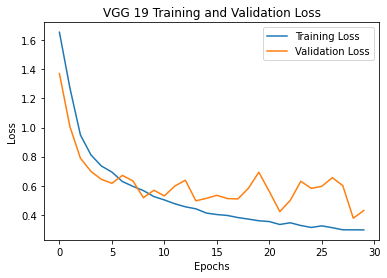

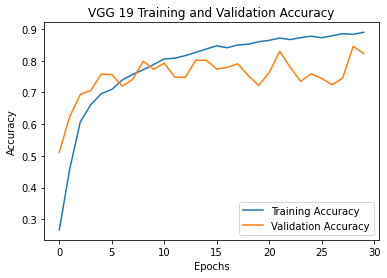

In [12]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 9s 35ms/step - loss: 0.4297 - acc: 0.8228
Loss: 0.42968857288360596
Accuracy: 0.8228105902671814


In [14]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 Training classification report:\n", train_class_report)

380/380 [==============================] - 80s 209ms/step

VGG 19 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19161   0.17213   0.18135      1220
            covid19    0.20102   0.19067   0.19571      1243
             normal    0.22214   0.23887   0.23020      1235
       tuberculosis    0.19284   0.18889   0.19085      1170
    viral_pneumonia    0.19835   0.21782   0.20763      1212

           accuracy                        0.20181      6080
          macro avg    0.20119   0.20168   0.20115      6080
       weighted avg    0.20131   0.20181   0.20127      6080



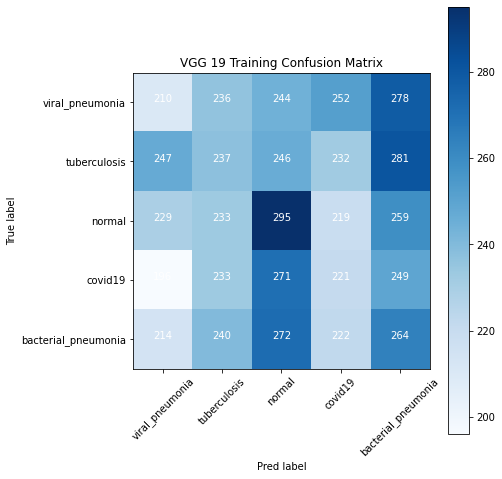

In [15]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [16]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(256,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(64,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_______________________________________________________

In [17]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback,
)

Epoch 1/30
380/380 [==============================] - 103s 247ms/step - loss: 1.6475 - acc: 0.2566 - val_loss: 1.4841 - val_acc: 0.3422
Epoch 2/30
380/380 [==============================] - 91s 240ms/step - loss: 1.4462 - acc: 0.3637 - val_loss: 1.3521 - val_acc: 0.4420
Epoch 3/30
380/380 [==============================] - 92s 242ms/step - loss: 1.2830 - acc: 0.4428 - val_loss: 1.2304 - val_acc: 0.5081
Epoch 4/30
380/380 [==============================] - 91s 240ms/step - loss: 1.1530 - acc: 0.5095 - val_loss: 1.1255 - val_acc: 0.5499
Epoch 5/30
380/380 [==============================] - 91s 240ms/step - loss: 1.0631 - acc: 0.5548 - val_loss: 1.0160 - val_acc: 0.5967
Epoch 6/30
380/380 [==============================] - 92s 241ms/step - loss: 0.9995 - acc: 0.5832 - val_loss: 0.9783 - val_acc: 0.6079
Epoch 7/30
380/380 [==============================] - 92s 243ms/step - loss: 0.9486 - acc: 0.5954 - val_loss: 0.9201 - val_acc: 0.6446
Epoch 8/30
380/380 [==============================] - 

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

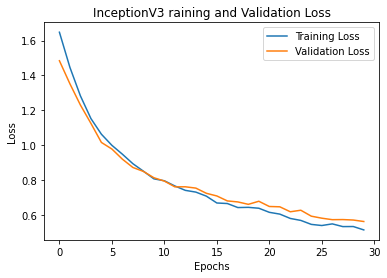

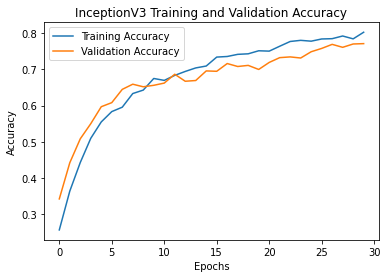

In [18]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 raining and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 6s 25ms/step - loss: 0.5630 - acc: 0.7709
Loss: 0.5629634261131287
Accuracy: 0.7708757519721985


In [20]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 Training classification report:\n", train_class_report)



380/380 [==============================] - 83s 215ms/step

InceptionV3 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20945   0.21803   0.21365      1220
            covid19    0.20570   0.18584   0.19527      1243
             normal    0.20031   0.20810   0.20413      1235
       tuberculosis    0.20082   0.21026   0.20543      1170
    viral_pneumonia    0.19932   0.19389   0.19657      1212

           accuracy                        0.20312      6080
          macro avg    0.20312   0.20322   0.20301      6080
       weighted avg    0.20315   0.20312   0.20297      6080



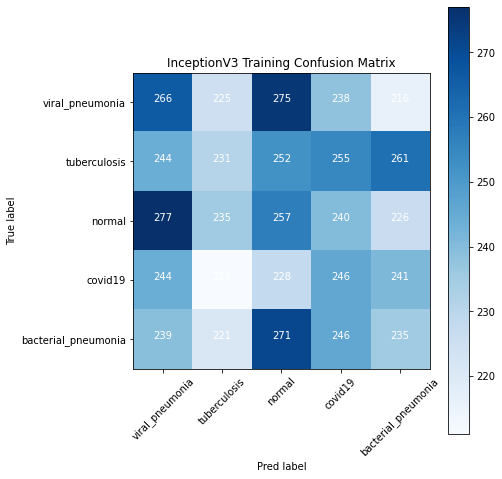

In [21]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()